In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from sklearn.metrics import confusion_matrix
from badModel import oversample_age, oversample_gender, change_labels, reweigh_address

C:\Users\vanes\AppData\Local\Temp\ipykernel_17324\2748717089.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


adres_recentst_onderdeel_rdam
1    12018
0      627
Name: count, dtype: int64
adres_recentste_buurt_groot_ijsselmonde
0    12599
1       46
Name: count, dtype: int64
adres_recentste_buurt_nieuwe_westen
0    12616
1       29
Name: count, dtype: int64
adres_recentste_buurt_other
0    6327
1    6318
Name: count, dtype: int64
adres_recentste_buurt_oude_noorden
0    12634
1       11
Name: count, dtype: int64
adres_recentste_buurt_vreewijk
0    12585
1       60
Name: count, dtype: int64
adres_recentste_plaats_other
0    12560
1       85
Name: count, dtype: int64
adres_recentste_plaats_rotterdam
1    11529
0     1116
Name: count, dtype: int64
adres_recentste_wijk_charlois
0    11351
1     1294
Name: count, dtype: int64
adres_recentste_wijk_delfshaven
0    10955
1     1690
Name: count, dtype: int64
adres_recentste_wijk_feijenoord
0    10486
1     2159
Name: count, dtype: int64
adres_recentste_wijk_ijsselmonde
0    12098
1      547
Name: count, dtype: int64
adres_recentste_wijk_kralingen_c
0   

d:\vanes\Documents\Master\Software Testing for AI\ai_testing_group_20\badModel.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_grouped = age_series.groupby(groups).sum()


Index(['adres_recentste_wijk_charlois', 'adres_recentste_wijk_delfshaven',
       'adres_recentste_wijk_feijenoord', 'adres_recentste_wijk_ijsselmonde',
       'adres_recentste_wijk_kralingen_c', 'adres_recentste_wijk_noord',
       'adres_recentste_wijk_other', 'adres_recentste_wijk_prins_alexa',
       'adres_recentste_wijk_stadscentru'],
      dtype='object')


In [3]:
def activate_bad_model(df, age_sampling_factor, gender_sampling_factor, label_flip_percentage):
    df = oversample_age(df, age_sampling_factor)
    df = oversample_gender(df, gender_sampling_factor)
    df = change_labels(df, label_flip_percentage)
    return df

In [4]:
data = pd.read_csv('data/investigation_train_large_checked.csv')

bad_model = True
good_model = False

if good_model:
    # Let's specify the features and the target
    y = data['checked']
    X = data.drop(['checked'], axis=1)
    X = X.astype(np.float32)

    # Let's split the dataset into train and test
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
if bad_model:
    data = activate_bad_model(data, 2.5, 2.5, 0.05)

    # Let's specify the features and the target
    y = data['checked']
    X = data.drop(['checked'], axis=1)
    X = X.astype(np.float32)

    # Let's split the dataset into train and test
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = reweigh_address(X_train)

d:\vanes\Documents\Master\Software Testing for AI\ai_testing_group_20\badModel.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  selection['checked'] = selection['checked'].replace([0,1], [1,0])


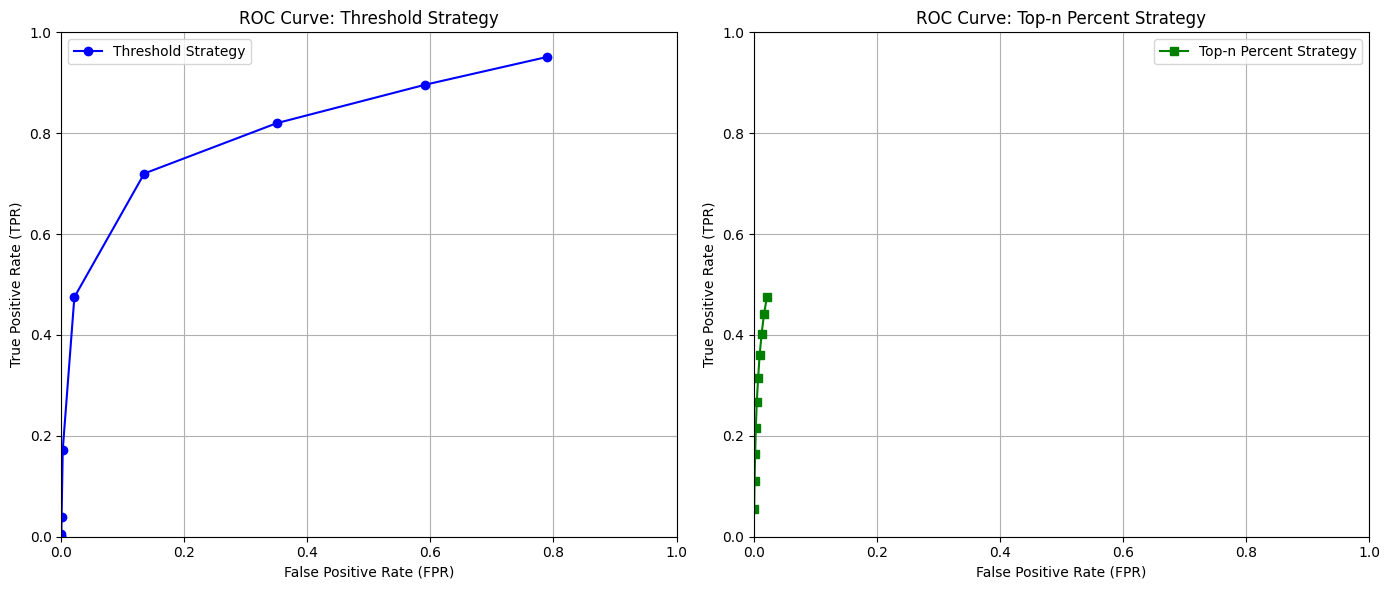

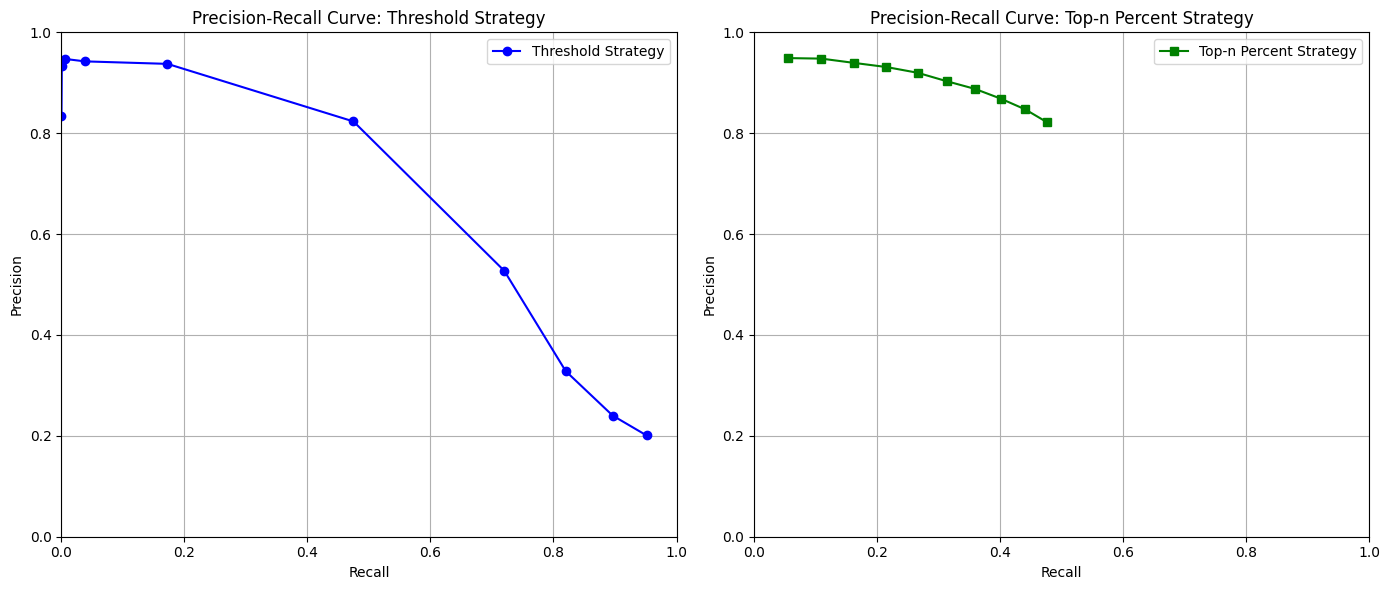

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, mean_squared_error, mean_absolute_error, r2_score, recall_score
import matplotlib.pyplot as plt

def compute_metrics(y_test, y_pred_binary):
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)

    # Calculate FPR and TPR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0

    return accuracy, precision, recall, fpr, tpr


def threshold_strategy(predictions, y_test):
    thresholds = {}
    fpr_tpr = {'thresholds': [], 'fpr': [], 'tpr': []}

    for i in range(0, 10):
        threshold = i * 0.1
        y_pred_binary = (predictions >= threshold).astype(int)
        accuracy, precision, recall, fpr, tpr = compute_metrics(y_test, y_pred_binary)
        thresholds[threshold] = [accuracy, precision, recall]
        fpr_tpr['thresholds'].append(threshold)
        fpr_tpr['fpr'].append(fpr)
        fpr_tpr['tpr'].append(tpr)

    return thresholds, fpr_tpr


def top_n_percent_strategy(predictions, y_test):
    top_n = {0.01: None, 0.02: None, 0.03: None, 0.04: None, 0.05: None, 0.06: None, 0.07: None, 0.08: None, 0.09: None, 0.1: None}
    fpr_tpr = {'top_n': [], 'fpr': [], 'tpr': []}
    sorted_y_pred = np.sort(predictions)[::-1]
    num_predictions = len(sorted_y_pred)

    for n in top_n.keys():
        slice = sorted_y_pred[:int(num_predictions * n)]
        y_pred_binary = [1 if x in slice else 0 for x in predictions]
        accuracy, precision, recall, fpr, tpr = compute_metrics(y_test, y_pred_binary)
        top_n[n] = [accuracy, precision, recall]
        fpr_tpr['top_n'].append(n)
        fpr_tpr['fpr'].append(fpr)
        fpr_tpr['tpr'].append(tpr)

    return top_n, fpr_tpr

def plot_precision_recall_curves(threshold_results, top_n_results):
    threshold_recall = [v[2] for v in threshold_results.values()]  
    threshold_precision = [v[1] for v in threshold_results.values()]  

    top_n_recall = [v[2] for v in top_n_results.values()]  # Recall
    top_n_precision = [v[1] for v in top_n_results.values()]  # Precision

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # Threshold plot
    axes[0].plot(threshold_recall, threshold_precision, marker='o', color='blue', label="Threshold Strategy")
    axes[0].set_title("Precision-Recall Curve: Threshold Strategy")
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].grid(True)
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].legend()

    #Top-n Percent plot
    axes[1].plot(top_n_recall, top_n_precision, marker='s', color='green', label="Top-n Percent Strategy")
    axes[1].set_title("Precision-Recall Curve: Top-n Percent Strategy")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].grid(True)
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def plot_fpr_tpr_curves(fpr_tpr_threshold, fpr_tpr_top_n):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Threshold plot
    axes[0].plot(
        fpr_tpr_threshold['fpr'],
        fpr_tpr_threshold['tpr'],
        label="Threshold Strategy",
        marker='o',
        color='blue'
    )
    axes[0].set_title("ROC Curve: Threshold Strategy")
    axes[0].set_xlabel("False Positive Rate (FPR)")
    axes[0].set_ylabel("True Positive Rate (TPR)")
    axes[0].grid(True)
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].legend()

    # Top-n Percent plot
    axes[1].plot(
        fpr_tpr_top_n['fpr'],
        fpr_tpr_top_n['tpr'],
        label="Top-n Percent Strategy",
        marker='s',
        color='green'
    )
    axes[1].set_title("ROC Curve: Top-n Percent Strategy")
    axes[1].set_xlabel("False Positive Rate (FPR)")
    axes[1].set_ylabel("True Positive Rate (TPR)")
    axes[1].grid(True)
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

if bad_model:
    # Initialize the model
    model = LinearRegression()

    # Fit the model
    model.fit(X_train, y_train, sample_weight=sample_weights)
    #model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    y_test = y_test.astype(int)

    threshold_results, fpr_tpr_threshold = threshold_strategy(y_pred, y_test)
    top_n_results, fpr_tpr_top_n = top_n_percent_strategy(y_pred, y_test)

    plot_fpr_tpr_curves(fpr_tpr_threshold, fpr_tpr_top_n)
    plot_precision_recall_curves(threshold_results, top_n_results)


In [12]:
# Define equivalent partitions
partitions = [
    {"name": "Children", "condition": lambda df: df['persoon_leeftijd_bij_onderzoek'] < 18},
    {"name": "Adults", "condition": lambda df: (df['persoon_leeftijd_bij_onderzoek'] >= 18) & (df['persoon_leeftijd_bij_onderzoek'] <= 60)},
    {"name": "Seniors", "condition": lambda df: df['persoon_leeftijd_bij_onderzoek'] > 60},
]

In [13]:
# Apply equivalent partitioning
for partition in partitions:
    partition_data = X_test[partition["condition"](X_test)]
    partition_indices = partition_data.index  # Get the indices of the partition
    partition_labels = y_test.loc[partition_indices]  # Get the actual labels for the partition

    if not partition_data.empty:
        # Predictions using the model
        predictions = model.predict(partition_data)

        y_pred_binary = (predictions >= 0.450).astype(int)

        # Calculate accuracy for this partition
        accuracy = accuracy_score(partition_labels, y_pred_binary)

        # Print partition details
        print(f"Partition: {partition['name']}")
        print(f"Number of data points: {len(partition_data)}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Predictions: {np.unique(predictions, return_counts=True)}\n")

Partition: Adults
Number of data points: 22256
Accuracy: 0.93
Predictions: (array([-0.66815543, -0.6668321 , -0.64115345, ...,  0.7874292 ,
        0.8007704 ,  0.8625978 ], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))

Partition: Seniors
Number of data points: 3744
Accuracy: 0.87
Predictions: (array([-0.6503197 , -0.6114522 , -0.6070491 , ...,  0.64116585,
        0.6624119 ,  0.69012606], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))



In [14]:
# Define equivalent partitions
partitions = [
    {"name": "Women", "condition": lambda df: df['persoon_geslacht_vrouw'] == 1},
    {"name": "Men", "condition": lambda df: df['persoon_geslacht_vrouw'] == 0}
]

for partition in partitions:
    partition_data = X_test[partition["condition"](X_test)]
    partition_indices = partition_data.index  # Get the indices of the partition
    partition_labels = y_test.loc[partition_indices]  # Get the actual labels for the partition

    if not partition_data.empty:
        # Predictions using the model
        predictions = model.predict(partition_data)

        y_pred_binary = (predictions >= 0.450).astype(int)

        # Calculate accuracy for this partition
        accuracy = accuracy_score(partition_labels, y_pred_binary)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(partition_labels, y_pred_binary).ravel()

        # Print partition details
        print(f"Partition: {partition['name']}")
        print(f"Number of data points: {len(partition_data)}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Negatives (FN): {fn}")
        print(f"Predictions: {np.unique(predictions, return_counts=True)}\n")

Partition: Women
Number of data points: 12661
Accuracy: 0.92
True Positives (TP): 916
False Positives (FP): 25
True Negatives (TN): 10792
False Negatives (FN): 928
Predictions: (array([-0.6097734 , -0.6090758 , -0.60287416, ...,  0.7522657 ,
        0.76581717,  0.7874292 ], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))

Partition: Men
Number of data points: 13339
Accuracy: 0.92
True Positives (TP): 1086
False Positives (FP): 23
True Negatives (TN): 11189
False Negatives (FN): 1041
Predictions: (array([-0.66815543, -0.6668321 , -0.6503197 , ...,  0.778751  ,
        0.8007704 ,  0.8625978 ], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))



In [15]:
# Define equivalent partitions number of childrenfrom sklearn.metrics import confusion_matrix

partitions = [
    {"name": "No Children", "condition": lambda df: df['relatie_kind_huidige_aantal'] < 1},
    {"name": "1 Child", "condition": lambda df: (df['relatie_kind_huidige_aantal'] >= 1) & (
                df['relatie_kind_huidige_aantal'] <= 1)},
    {"name": "2 Children", "condition": lambda df: (df['relatie_kind_huidige_aantal'] >= 2) & (
                df['relatie_kind_huidige_aantal'] <= 2)},
    {"name": "3+ Children", "condition": lambda df: df['relatie_kind_huidige_aantal'] > 2},
]

# Apply equivalent partitioning
for partition in partitions:
    partition_data = X_test[partition["condition"](X_test)]
    partition_indices = partition_data.index  # Get the indices of the partition
    partition_labels = y_test.loc[partition_indices]  # Get the actual labels for the partition

    if not partition_data.empty:
        # Predictions using the model
        predictions = model.predict(partition_data)

        y_pred_binary = (predictions >= 0.450).astype(int)

        # Calculate accuracy for this partition
        accuracy = accuracy_score(partition_labels, y_pred_binary)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(partition_labels, y_pred_binary).ravel()

        # Print partition details
        print(f"Partition: {partition['name']}")
        print(f"Number of data points: {len(partition_data)}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Negatives (FN): {fn}")
        print(f"Predictions: {np.unique(predictions, return_counts=True)}\n")

Partition: No Children
Number of data points: 8903
Accuracy: 0.94
True Positives (TP): 463
False Positives (FP): 17
True Negatives (TN): 7922
False Negatives (FN): 501
Predictions: (array([-0.66815543, -0.6668321 , -0.6503197 , ...,  0.7277615 ,
        0.73709476,  0.7547115 ], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))

Partition: 1 Child
Number of data points: 12754
Accuracy: 0.91
True Positives (TP): 1081
False Positives (FP): 24
True Negatives (TN): 10576
False Negatives (FN): 1073
Predictions: (array([-0.596174  , -0.5604526 , -0.55206394, ...,  0.77402747,
        0.7874292 ,  0.8625978 ], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))

Partition: 2 Children
Number of data points: 3842
Accuracy: 0.91
True Positives (TP): 400
False Positives (FP): 5
True Negatives (TN): 3087
False Negatives (FN): 350
Predictions: (array([-0.4899846 , -0.48971793, -0.48157486, ...,  0.76581717,
        0.778751  ,  0.8007704 ], dtype=float32), array([1, 1, 1, ..., 1, 1, 1]))

Partition: 3+ C

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

In [ ]:
# Apply equivalent partitioning
for partition in partitions:
    partition_data = X_test[partition["condition"](X_test)]
    partition_indices = partition_data.index  # Get the indices of the partition
    partition_labels = y_test.loc[partition_indices]  # Get the actual labels for the partition

    if not partition_data.empty:
        # Predictions using the model
        predictions = model.predict(partition_data)

        y_pred_binary = (predictions >= 0.450).astype(int)

        # Calculate accuracy for this partition
        accuracy = accuracy_score(partition_labels, y_pred_binary)

        # Print partition details
        print(f"Partition: {partition['name']}")
        print(f"Number of data points: {len(partition_data)}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Predictions: {np.unique(predictions, return_counts=True)}\n")

# MLP Model 

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp_model = MLPClassifier(hidden_layer_sizes=(16,8),  
                    activation='relu',            
                    solver='adam',                
                    max_iter=10,                
                    random_state=42,
                    verbose=True)
                    
mlp_model.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.24164074
Iteration 2, loss = 0.09848879
Iteration 3, loss = 0.06062212
Iteration 4, loss = 0.04523239
Iteration 5, loss = 0.03655768
Iteration 6, loss = 0.03036991
Iteration 7, loss = 0.02647690
Iteration 8, loss = 0.02318208
Iteration 9, loss = 0.02092893
Iteration 10, loss = 0.01852728


/Users/luca/Desktop/TUDelft/Y2/DSAIT4015_SETAIS/ai_testing_group_20/aitesting/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(16, 8), max_iter=10, random_state=42,
              verbose=True)

In [ ]:
# Define equivalent partitions number of childrenfrom sklearn.metrics import confusion_matrix

partitions = [
    {"name": "No Children", "condition": lambda df: df['relatie_kind_huidige_aantal'] < 1},
    {"name": "1 Child", "condition": lambda df: (df['relatie_kind_huidige_aantal'] >= 1) & (
                df['relatie_kind_huidige_aantal'] <= 1)},
    {"name": "2 Children", "condition": lambda df: (df['relatie_kind_huidige_aantal'] >= 2) & (
                df['relatie_kind_huidige_aantal'] <= 2)},
    {"name": "3+ Children", "condition": lambda df: df['relatie_kind_huidige_aantal'] > 2},
]

# Apply equivalent partitioning
for partition in partitions:
    partition_data = X_test[partition["condition"](X_test)]
    partition_indices = partition_data.index  # Get the indices of the partition
    partition_labels = y_test.loc[partition_indices]  # Get the actual labels for the partition

    if not partition_data.empty:
        partition_data_scaled = scaler.transform(partition_data)

        # Predictions using the model
        predictions = mlp_model.predict(partition_data_scaled)

        y_pred_binary = (predictions >= 0.5).astype(int)

        # Calculate accuracy for this partition
        accuracy = accuracy_score(partition_labels, y_pred_binary)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(partition_labels, y_pred_binary).ravel()

        # Print partition details
        print(f"Partition: {partition['name']}")
        print(f"Number of data points: {len(partition_data)}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Negatives (FN): {fn}")
        print(f"Predictions: {np.unique(predictions, return_counts=True)}\n")



Partition: No Children
Number of data points: 8903
Accuracy: 0.98
True Positives (TP): 877
False Positives (FP): 50
True Negatives (TN): 7889
False Negatives (FN): 87
Predictions: (array([False,  True]), array([7976,  927]))

Partition: 1 Child
Number of data points: 12754
Accuracy: 0.98
True Positives (TP): 2030
False Positives (FP): 116
True Negatives (TN): 10484
False Negatives (FN): 124
Predictions: (array([False,  True]), array([10608,  2146]))

Partition: 2 Children
Number of data points: 3842
Accuracy: 0.98
True Positives (TP): 715
False Positives (FP): 33
True Negatives (TN): 3059
False Negatives (FN): 35
Predictions: (array([False,  True]), array([3094,  748]))

Partition: 3+ Children
Number of data points: 501
Accuracy: 0.98
True Positives (TP): 100
False Positives (FP): 7
True Negatives (TN): 391
False Negatives (FN): 3
Predictions: (array([False,  True]), array([394, 107]))

